In [1]:
from keras.applications import VGG16
img_rows = 128
img_cols = 128

# Re-loads the VGG16 model without the top or FC layers
vgg16 = VGG16(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))

# Here we freeze the last 4 layers 
# Layers are set to trainable as True by default
for layer in vgg16.layers:
    layer.trainable = False
    
# Print our layers 
for (i,layer) in enumerate(vgg16.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

ModuleNotFoundError: No module named 'keras'

In [4]:
def addTopModel(bottom_model, num_classes, D=256):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""
    top_model = bottom_model.output
    top_model = Flatten(name = "flatten")(top_model)
    top_model = Dense(D, activation = "relu")(top_model)
    top_model = Dropout(0.3)(top_model)
    top_model = Dense(num_classes, activation = "softmax")(top_model)
    return top_model

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model

num_classes = 6

FC_Head = addTopModel(vgg16, num_classes)

model = Model(inputs=vgg16.input, outputs=FC_Head)

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
__________

In [6]:
from keras.preprocessing.image import ImageDataGenerator

train_data_dir = './data/train'
validation_data_dir = './data/valid'

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
train_batchsize = 20
val_batchsize = 16
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=train_batchsize,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 1891 images belonging to 6 classes.
Found 630 images belonging to 6 classes.


In [ ]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
                   
checkpoint = ModelCheckpoint("/home/recycle_check.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 10,
                          verbose = 1,
                          restore_best_weights = True)


reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.5,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0002)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint, reduce_lr]

# Note we use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.01),
              metrics = ['accuracy'])

nb_train_samples = 1891
nb_validation_samples = 630
epochs = 20
batch_size = 20

history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // 25)

model.save("/home/recycle.h5")

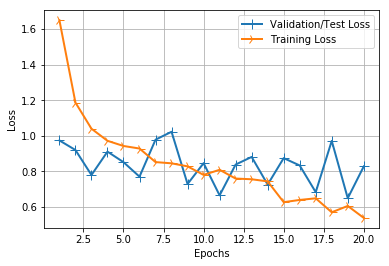

In [10]:
# Plotting our loss charts
import matplotlib.pyplot as plt

history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

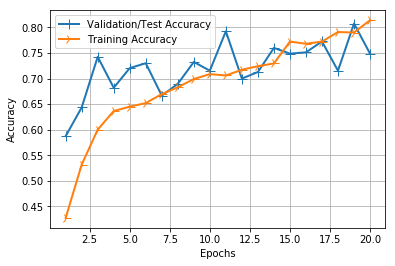

In [11]:
# Plotting our accuracy charts
import matplotlib.pyplot as plt

history_dict = history.history

acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label='Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

In [10]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from keras.models import load_model

img_row, img_height, img_depth = 100,100, 3
model = load_model('/home/deeplearningcv/DeepLearningCV/Trained Models/recycle2.h5')

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())
nb_train_samples = 1262
nb_validation_samples = 630

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, nb_validation_samples)
y_pred = np.argmax(Y_pred, axis=1)

target_names = list(class_labels.values())

plt.figure(figsize=(20,20))
print(y_pred)
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)


plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

KeyboardInterrupt: 

In [1]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import os
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
import re

def draw_test(name, pred, im, true_label):
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 160, 0, 0, 500 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, "predited - "+ pred, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    cv2.putText(expanded_image, "true - "+ true_label, (20, 120) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,255,0), 2)
    cv2.imshow(name, expanded_image)


def getRandomImage(path, img_width, img_height):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    final_path = file_path + "/" + image_name
    
    print(final_path)
    return image.load_img(final_path, target_size = (img_width, img_height)), final_path, path_class

# dimensions of our images
img_width, img_height = 100,100
img_row, img_height, img_depth = 100, 100, 3
model = load_model('/home/deeplearningcv/DeepLearningCV/Trained Models/recycle2.h5')

files = []
predictions = []
true_labels = []
# predicting images
for i in range(0, 10):
    path = './data/valid/' 
    img, final_path, true_label = getRandomImage(path, img_width, img_height)
    files.append(final_path)
    true_labels.append(true_label)
    x = image.img_to_array(img)
    x = x * 1./255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = model.predict(images, batch_size = 10)
    print(str(classes))
    final = np.argmax(classes,axis=-1)
    arr = ["Cardboard","glass","metal", "paper", "plastic", "trash" ]
    print(arr[final[0]])
    a = arr[final[0]]
    predictions.append(str(a))
    
for i in range(0, len(files)):
    image = cv2.imread((files[i]))
    draw_test("Prediction", predictions[i], image, true_labels[i]) 
#     draw_test("Prediction", predictions[i], image, true_labels[i])
    cv2.waitKey(0)
    


Using TensorFlow backend.


./data/valid/metal/metal272.jpg
[[7.1035793e-05 5.8908051e-01 2.0729059e-01 5.5257353e-04 1.9283430e-01
  1.0170858e-02]]
glass
./data/valid/metal/metal21.jpg
[[1.9789517e-05 3.4158051e-01 5.6597090e-01 5.3027775e-03 8.6539656e-02
  5.8630237e-04]]
metal
./data/valid/plastic/plastic342.jpg
[[8.2870210e-06 2.5316703e-01 9.3680015e-03 2.0920706e-04 6.6413724e-01
  7.3110230e-02]]
plastic
./data/valid/glass/glass223.jpg
[[0.00295143 0.56556165 0.15431285 0.01741847 0.17962983 0.08012576]]
glass
./data/valid/cardboard/cardboard21.jpg
[[9.99823391e-01 1.08839117e-07 5.85621385e-10 1.56469017e-04
  1.98770431e-05 1.10939006e-07]]
Cardboard
./data/valid/metal/metal216.jpg
[[5.7553855e-08 4.5769252e-03 9.9475229e-01 4.3121905e-05 6.2208279e-04
  5.5097007e-06]]
metal
./data/valid/metal/metal383.jpg
[[2.1442250e-04 5.9340008e-02 6.1275887e-01 3.2548282e-01 1.9269584e-03
  2.7685065e-04]]
metal
./data/valid/plastic/plastic280.jpg
[[2.0756200e-04 2.4463972e-01 1.7434448e-01 3.9128408e-02 5.272852